# Deviance information criterion (DIC)

https://www.rdocumentation.org/packages/SpatialExtremes/versions/2.0-7.2/topics/DIC

In [1]:
from jax import random
import jax.numpy as np
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
numpyro.set_host_device_count(3)
numpyro.enable_validation()

## Define two models 

In [2]:
x = np.linspace(-1, 1)
t = 2.5 * x + onp.random.normal(loc=0, scale=.5, size=len(x))

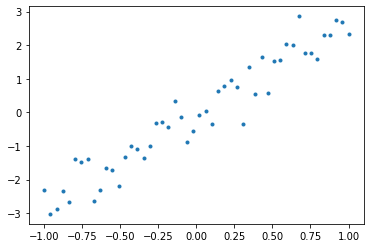

In [3]:
plt.plot(x, t, '.')

In [4]:
def model1_fn(x, t):
    m = numpyro.sample('m', dist.Normal(0, 1e6))
    std = numpyro.sample('std', dist.InverseGamma(2.5, 2.5 * 10))
    
    y = m * x
    numpyro.sample('y', dist.Normal(y, std), obs=t)

kernel = NUTS(model1_fn)
model1 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model1.run(rng_key, collect_warmup=False, x=x, t=t)
samples1 = model1.get_samples()
model1.print_summary() 

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/numpyro/infer/mcmc.py:630: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(3)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      2.74      0.19      2.74      2.44      3.05  11940.44      1.00
       std      0.77      0.09      0.76      0.61      0.92  11398.60      1.00

Number of divergences: 0


In [5]:
def model2_fn(x, t):
    m1 = numpyro.sample('m1', dist.Normal(0, 1e6))
    m2 = numpyro.sample('m2', dist.Normal(0, 1e6))
    std = numpyro.sample('std', dist.InverseGamma(2.5, 2.5 * 10))
    
    y = m1 * x + m2 * x**3
    numpyro.sample('y', dist.Normal(y, std), obs=t)

kernel = NUTS(model2_fn)
model2 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model2.run(rng_key, collect_warmup=False, x=x, t=t)
samples2 = model2.get_samples()
model2.print_summary() 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        m1      2.88      0.47      2.88      2.13      3.68   5660.40      1.00
        m2     -0.23      0.69     -0.22     -1.38      0.90   5613.02      1.00
       std      0.78      0.10      0.77      0.62      0.93   5906.66      1.00

Number of divergences: 0


## DIC

The deviance is

$$
D(\theta) = -2 \log \pi(Y \mid \theta),
$$

where $y$ are the data, $\theta$ are the unknown parameters of the models and $\pi(Y|\theta)$ is the likelihood function. 

where 

$$
\pi(Y|\theta) = \prod_i^n \pi(y_i|\theta)
$$

and

$$
\log \pi(Y|\theta) = \sum_i^n \log \pi(y_i|\theta)
$$

for $n$ data points.

Thus the expected deviance, a measure of how well the model fits the data, is given by

$$
\overline{D} = {\rm E}_{\theta}[D(\theta)],
$$

while the effective number of parameters is

$$
p_D = \overline{D} - D(\theta^*),
$$

where $\theta^*$ is point estimate of the posterior distribution, e.g., the posterior mean. Finally the DIC is given by

$$
{\rm DIC} = p_D + \overline{D}.
$$

In [6]:
def dic(model_fn, samples, **kwargs):
    pi_theta = numpyro.infer.log_likelihood(model_fn, samples, **kwargs)['y'].sum(axis=1)
    D_bar = -2 * pi_theta.mean(axis=0)
    theta_star = {k: v.mean(keepdims=True) for k, v in samples.items()}
    pi_theta_star = numpyro.infer.log_likelihood(model_fn, theta_star, **kwargs)['y'].sum()
    D_theta_star = -2 * pi_theta_star
    print('expected deviance:', D_bar)
    print('effective number of parameters:', D_bar - D_theta_star)
    print('DIC:', D_bar - D_theta_star + D_bar)

In [7]:
dic(model1_fn, samples1, x=x, t=t)

expected deviance: 84.72308
effective number of parameters: 1.0654068
DIC: 85.78849


In [8]:
dic(model2_fn, samples2, x=x, t=t)

expected deviance: 86.38887
effective number of parameters: 2.0561523
DIC: 88.44502


models with smaller DIC should be preferred to models with larger DIC. Roughly speaking, differences of more than 10 might rule out the model with the higher DIC, differences between 5 and 10 are substantial.